**Leo Qian, Muqing Wen**

Spring 2023

CS 443: Bio-inspired Machine Learning

#### Week 1: Building jointed model arm

# Project 3: Outstar Learning and Motor Control

In this project, you will train a neural network to control a model 3-jointed arm so that it successfully reaches for one or more specified targets. The **Outstar learning rule** governs how weights are learned between between activation of neurons that sense the state of the arm and the required muscle movements to move toward the target. You will explore how you can use **self-supervised learning** to solve a complex task without pre-specified labels: the network learns how to move the arm by observing the consequences of the random movements that the arm makes. In other words, the model arm *learns by generating its own data about the world*.

The focus this week will be on building and visualizing the model arm. Next week, the focus will be on implementing and exploring how the Outstar learning rule works. With both the arm and the Outstar neural network implement, on the third week you will train the model arm to reach for targets. 

The neural network from this project comes from the paper:

    Grosse-Wentrup, M., & Contreras-Vidal, J. L. (2007).
    The role of the striatum in adaptation learning: a computational model. Biological Cybernetics, 96(4), 377-388.
    
*Isn't cybernetics such a cool word?* The original reference for the model (DIRECT) is:

    Bullock D, Grossberg S, Guenther FH (1993).
    A self-organizing neural model of motor equivalent reaching and tool use by a multijoint arm J Cogn Neurosci 5:408–435

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 16})
plt.show()

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

OSError: 'seaborn-v0_8-colorblind' not found in the style library and input is not a valid URL or path; see `style.available` for list of available styles

## Task 1: Build and visualize model arm

### Overview of the classes

The model arm is composed of the following components, each of which is its own class:
- `Joint` (`joint.py`): Each object represents ONE of the three arm joints (shoulder, elbow, wrist).
- `EndEffector` (`joint.py`): This is the hand that is attached to the wrist joint, which must intercept with a target (i.e. come in contact with the target).
- `Muscles` (`muscles.py`) (the "sink" layer): Each object represents the SIX arm muscles, each of which moves an arm joint through space. These six muscles are grouped in **agonist-antagonist pairs** and each pair controls the movement of one arm joint. For example, activation of the elbow agonist muscle moves the lower arm (forearm, wrist, and hand) CLOSER to the center (in front of the virtual person), while activation of the the elbow antagonist muscle moves the lower arm outward, AWAY from the center. *We represent all six muscles in a single object for efficiency — it allows for batch matrix multiplication by the Outstar network.*
- `MotorNeurons` (`motor_neurons.py`) (the "source" layer): The motorneurons sense the current state of the arm. Each object represents a large collection of neurons that activate the muscles (that in turn move the arm). Each neuron activates only when the 3 arm joints are approximately in the neuron's "preferred" configuration. For example, one neuron might "prefer" when the angle of shoulder joint is roughly 0° and the angle of the elbow joint is roughly 90° and the angle of the angle of the wrist joint is roughly 45°. Each neuron prefers a different combination of these angles.
- `Outstar` (`outstar.py`): Outstar neural network in which the source neurons are the `MotorNeurons` and the sink neurons are the `Muscles`. The network learns the **muscle (sink)** activations necessary to reach for the target given the activation pattern of the **motor neurons (source)**, which code the current state of the arm.

In [2]:
from joint import Joint, EndEffector
from model_arm import Arm

### 1a. Implement the `Joint` and `EndEffector` classes in `joint.py`

Each joint (shoulder, elbow, wrist) is represented by its own `Joint` object. A joint is specified by its:
- default angle at the beginning of each simulation (`initial_angle`)
- distance from the shoulder, which we assume is always centered at $(x, y) = (0, 0)$. (`dist2shoulder`). This distance is along the arm segments, NOT Euclidean distance. In other words, the distance to the shoulder never changes (*we assume the arm segments do not grow in length during a simulation!*)
- ergonomic limits on the angles that joints can take on (`angle_limits`). For example, most people's shoulder joint cannot assume angles less than -90° (without moving your torso)...that's just too far back behind you!

**Notes:**
- The `randomize_angle` method is used during training to set the joint to a random angle (within the ergonomic range) in between "babbles". This will be useful for allowing the model arm to "generate its own training data".

#### Test `Joint` class

In [3]:
test_joint = Joint('Test', 1.57, 7.5, (-5, 3))
print(f'{test_joint.get_dist2shoulder()=} and should be 7.5')
test_joint.reset_angle()
print(f'{test_joint.get_angle()=} and should be 1.57')
print(f'{test_joint.get_limits()=} and should be (-5, 3)')
a = np.zeros(1000)
for i in range(1000):
    test_joint.randomize_angle()
    a[i] = test_joint.get_angle()
print(f'After randomizing angles 1000 times, was it always between -5 and 3? {np.all(np.logical_and(a >= -5, a <= 3))}')
print(f'The angles generated were in fact different each time? {len(np.unique(a)) == 1000}')

test_joint.reset_angle()
test_joint.update_angle(np.array([2.12, 1.31]))
print(f'After updating angle {test_joint.get_angle()=} and it should be 1.5295')

np.random.seed(0)
test_joint.update_angle(np.array([0.12, 3.31]), angle_step=11*0.05)
b1 = test_joint.get_angle()
b2 = test_joint.update_angle(np.array([0.12, 3.31]), angle_step=0)
b2 = test_joint.get_angle()
b3 = test_joint.update_angle(np.array([0.12, 3.31]), angle_step=0)
b3 = test_joint.get_angle()
print(f'After joint overshoot beyond ergonomic limit, correction moves angle toward proper bounds? {b1 > b2 > b3}')

test_joint.get_dist2shoulder()=7.5 and should be 7.5
test_joint.get_angle()=1.57 and should be 1.57
test_joint.get_limits()=(-5, 3) and should be (-5, 3)
After randomizing angles 1000 times, was it always between -5 and 3? True
The angles generated were in fact different each time? True
After updating angle test_joint.get_angle()=1.5295 and it should be 1.5295
After joint overshoot beyond ergonomic limit, correction moves angle toward proper bounds? True


#### Test `EndEffector` class

In [4]:
test_effector = EndEffector('my_hand', 99)
print(f"The end effector's name is {test_effector.get_name()} and should be my_hand.")
print(f"The end effector's distance to shoulder is {test_effector.get_dist2shoulder()} and should be 99.")

The end effector's name is my_hand and should be my_hand.
The end effector's distance to shoulder is 99 and should be 99.


### Task 1b. Implement model arm (`Arm`) methods in `model_arm.py` through `randomize_joint_angles`

Although the `Arm` constructor has an argument for the Outstar network (*which has not been implemented yet*), pass in `None` and ignore it for now. At this point, **stop after implementing `randomize_joint_angles`** (i.e. do NOT implement `get_movement_dir` yet).

#### Notes about `get_joint_positions(self)`
This is the largest method in this task. It is responsible for returning an array (shape: `(4, 2)`) of the $(x, y)$ positions of the:
1. shoulder joint
2. elbow joint
3. wrist joint
4. hand (end effector)

Recall that the shoulder joint is at the origin `(x, y) = (0, 0)`. The $x$ coordinates in the `(4, 2)` positions array are computed as follows:

$$x_{shoulder} = 0$$
$$x_{elbow} = x_{shoulder} + l_0cos(\theta_{shoulder})$$
$$x_{wrist} = x_{elbow} + l_1cos(\theta_{shoulder} + \theta_{elbow})$$
$$x_{hand} = x_{wrist} + l_2cos(\theta_{shoulder} + \theta_{elbow} + \theta_{wrist})$$

where the $l_i$ is the length of the arm *segment* immediately preceding the joint (or end effector) — NOT distance to shoulder. The y coordinates are computed the same way, but replace `cos` with `sin`.

**Note:** `cos(x)` and `sin(x)` functions assume that `x` is an angle in **radians**. You can perform computations in radians or degrees, but be consistent. I will generally provide angles in radians.

#### Test `get_joint_positions`

In [5]:
joints = [Joint('j1', 0, 0, angle_limits=(-7, -3)),
          Joint('j2', 1, 2, angle_limits=(10, 15)),
          Joint('j3', 2, 3, angle_limits=(-2, 2))]
effector = EndEffector('hand', 4)
arm = Arm(joints, effector, None)
pos = arm.get_joint_positions()
print(75*'*')
print(f'Test 1: Positions:\nshoulder {pos[0]}, elbow {pos[1]}\nwrist {pos[2]}, hand {pos[3]}')
print('They should be:')
print('''shoulder [0. 0.], elbow [2. 0.]
wrist [2.54  0.841], hand [1.55  0.983]''')

joints = [Joint('j1', 1.5, 0, angle_limits=(-7, -3)),
          Joint('j2', 3, 4, angle_limits=(10, 15)),
          Joint('j3', 4.5, 5, angle_limits=(-2, 2))]
effector = EndEffector('hand', 4)
arm = Arm(joints, effector, None)
pos = arm.get_joint_positions()
print(75*'*')
print(f'Test 2: Positions:\nshoulder {pos[0]}, elbow {pos[1]}\nwrist {pos[2]}, hand {pos[3]}')
print('They should be:')
print('''shoulder [0. 0.], elbow [0.283 3.99 ]
wrist [0.072 3.012], hand [0.983 2.6  ]''')

***************************************************************************
Test 1: Positions:
shoulder [0. 0.], elbow [2. 0.]
wrist [2.54030231 0.84147098], hand [1.55030981 0.98259099]
They should be:
shoulder [0. 0.], elbow [2. 0.]
wrist [2.54  0.841], hand [1.55  0.983]
***************************************************************************
Test 2: Positions:
shoulder [0. 0.], elbow [0.28294881 3.98997995]
wrist [0.07215301 3.01244983], hand [0.98328327 2.60033134]
They should be:
shoulder [0. 0.], elbow [0.283 3.99 ]
wrist [0.072 3.012], hand [0.983 2.6  ]


### 1c. Visualize arm in reaching workspace

Implement the function in the cell below to return a set of shoulder, elbow, and wrist joints and hand end effector according to the following specifications. Use the joints and hand to create a model arm then call the `plot` method to create a plot showing your arm positioned in the workspace from a birds-eye (top-down) view.

#### Default arm posture: Joint and hand specifications

**Shoulder:** Initial joint angle of $\pi/8$. Joint angle limited to the range $(-\pi/2, \pi)$.

**Elbow:** Initial joint angle of $\pi/2$. Joint angle limited to the range $(0, \pi)$. Length of upper arm (connecting elbow and shoulder) is 28 cm.

**Wrist:** Initial joint angle of $\pi/3$. Joint angle limited to the range $(-\pi/2, \pi/2)$. Length of lower arm (connecting wrist and elbow) is 28 cm.

**Hand:** Distance from end-of-hand to wrist is 16 cm.

#### Goal

Your arm when plotted at the specified initial resting position should look like a `)` shape with the hand at x=0 (center) and y intersecting the 2nd inner-most circle.

*If you would like to develop your intuition about the joint angles, play around with the initial angles and see how it affects the arm configuration!*

#### Plotting note

You may wish to add the `%matplotlib inline` in the cell before you create your plot. You will shortly move your arm through the workspace and we will once again make use of `notebook` plotting mode. Recall that if you are in `notebook` mode, static plots "break" unless you are in `inline` mode. Enforcing `inline` mode here will help ensure that your plot works if you execute notebook cells out of order.

In [6]:
def create_joints_and_hand():
    '''Creates `Joint` objects for the shoulder, elbow, and wrist and `EndEffector` object (hand) in their default configuration (posture).
    
    Returns:
    -----------
    joints: list of `Joint`. len=3. The shoulder, elbow, and wrist joints (in that order).
    hand: `EndEffector`. Object representing the hand.
    '''
    shoulder = Joint("shoulder", np.pi/8, 0)
    elbow = Joint("elbow", np.pi/2, 28, (0, np.pi))
    wrist = Joint("wrist", np.pi/3, 56, (-np.pi/2, np.pi/2))

    hand = EndEffector("hand", 72)

    return (shoulder, elbow, wrist), hand

In [26]:
# TODO: Your code here to create joints, hand, arm and plot arm
joints, hand = create_joints_and_hand()

arm = Arm(joints, effector, None)

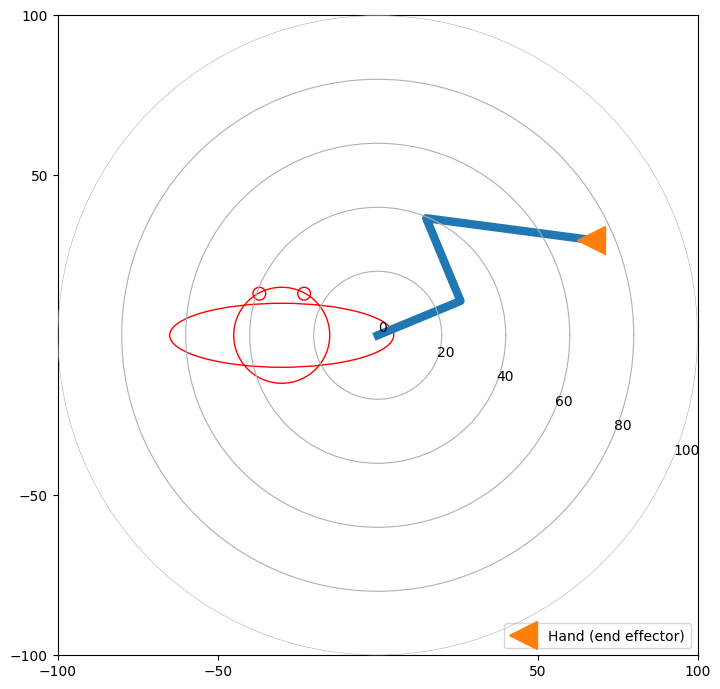

In [27]:
%matplotlib inline
# Plot arm in current configuration
from viz import ArmPlot
armPlot = ArmPlot()
armPlot.update(arm.get_joint_positions())

#### Test (1/2) plotting arm after randomizing angle

Complete the test code below. You should only be adding 2 lines of code.

Plotting the arm after randomizing the angle should result in the arm touching the nose!

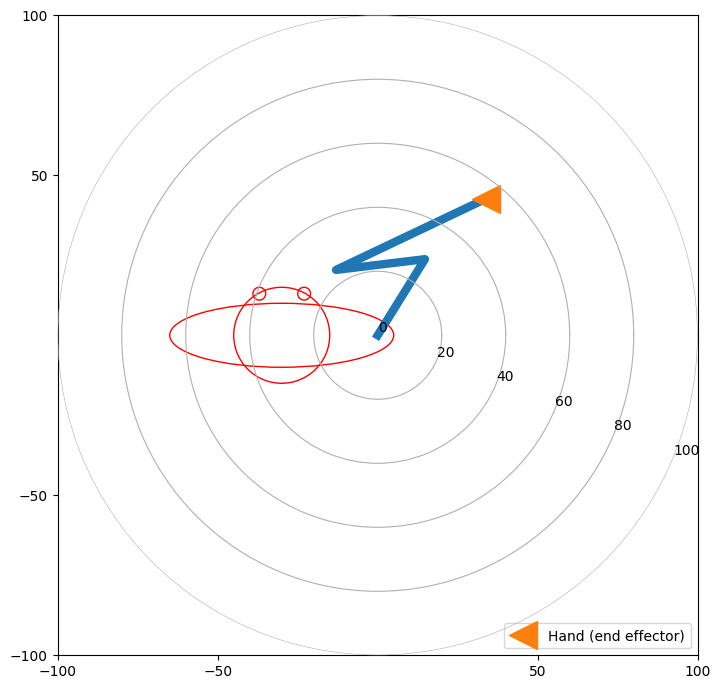

In [28]:
np.random.seed(0)
# TODO: Randomize all 3 joint angles
arm.randomize_joint_angles()

# TODO: Plot arm after randomizing joint angles configuration
%matplotlib inline
armPlot = ArmPlot()
armPlot.update(arm.get_joint_positions())

#### Test (2/2) plotting arm after randomizing angle

Complete the test code below. You should only be adding 2 lines of code.

Plotting after randomizing the angle should show the arm fully extended ("straight") and reaching out at roughly a +45° angle.

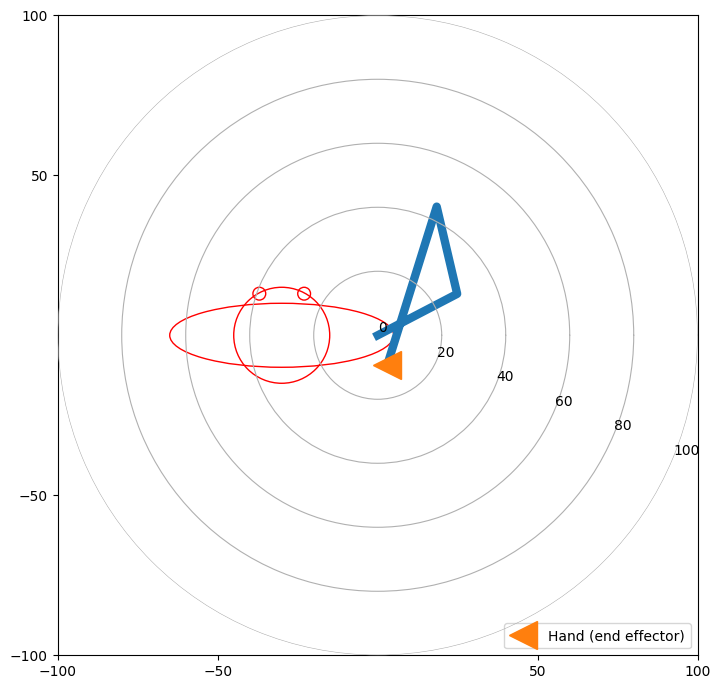

In [29]:
np.random.seed(2)
# TODO: Plot arm after randomizing joint angles configuration
arm.randomize_joint_angles()
armPlot = ArmPlot()
armPlot.update(arm.get_joint_positions())

# TODO: Plot arm after randomizing joint angles configuration
%matplotlib inline
arm.randomize_joint_angles()
armPlot = ArmPlot()
armPlot.update(arm.get_joint_positions())

## Task 2: Moving the arm with muscles

### 2a. Testing and visualizing arm movement

The activation of muscles are responsible for moving the arm by *changing the angles* of nearby joints on the arm (`update_angle` method in `Joint`). Before implementing the arm muscles, we will simulate their effect using your existing code. This will allow you to explore how the activations of specific muscles (e.g. attached to shoulder, elbow, etc) move the arm and test to make sure the range of motion of your joint work as expected (i.e. joint angles do not go out-of-bounds).

**TODO:** Complete the test code below then run the test cases and make sure the animations show the expected movement.

In [ ]:
def muscle_tester(which, n_steps=10, rate=1):
    # TODO: Make joints, hand, and arm here. Use the same config as in Task 1.

    
    # Mock muscle activations for testing. 2 muscles (one agonist/antagonist pair) simulated.
    act_phase_1 = np.array([1, 0])
    act_phase_2 = np.array([0, 1])
    if which == 'shoulder':
        print('Testing shoulder...')
        # Move right        
        test_muscle(arm, act_phase_1, 0, rot_rate=rate*0.05, n_steps=n_steps)
        # Move left
        test_muscle(arm, act_phase_2, 0, rot_rate=rate*0.05, n_steps=n_steps)
    elif which == 'shoulder_oob_back':
        print('Testing swinging arm back at shoulder joint...')
        # Swing arm back        
        test_muscle(arm, act_phase_1, 0, rot_rate=rate*0.05, n_steps=n_steps)
    elif which == 'shoulder_oob_across':
        print('Testing swinging arm across at shoulder joint...')
        # Swing arm across        
        test_muscle(arm, act_phase_2, 0, rot_rate=rate*0.05, n_steps=n_steps)
    elif which == 'elbow':
        print('Testing elbow...')
        # Move right        
        test_muscle(arm, act_phase_1, 1, rot_rate=rate*0.05, n_steps=n_steps)
        # Move left
        test_muscle(arm, act_phase_2, 1, rot_rate=rate*0.05, n_steps=n_steps)
    elif which == 'wrist':
        print('Testing wrist...')
        # Move right        
        test_muscle(arm, act_phase_1, 2, rot_rate=rate*0.05, n_steps=n_steps)
        # Move left
        test_muscle(arm, act_phase_2, 2, rot_rate=rate*0.05, n_steps=n_steps)
    elif which == 'arm':
        print('Testing whole arm...')
        # Move right        
        test_muscles(arm, act_phase_2, rot_rate=rate*0.05, n_steps=n_steps)
        # Move left
        test_muscles(arm, act_phase_1, rot_rate=rate*0.05, n_steps=n_steps)
        

def test_muscle(arm, muscle_acts, joint_ind, rot_rate=1, n_steps=10):
    arm.plot()
    for t in range(n_steps):
        joint = arm.get_joints()[joint_ind]
        joint.update_angle(muscle_acts, angle_step=rot_rate)
        arm.plot()

        
def test_muscles(arm, muscle_acts, rot_rate=1, n_steps=10):
    arm.plot()
    for t in range(n_steps):
        joints = arm.get_joints()
        for joint in joints:
            joint.update_angle(muscle_acts, angle_step=rot_rate)
        arm.plot()

#### Test: Shoulder

Running the following code should result in the arm rigidly rotating right at the shoulder joint then left back to the initial posture. The arm itself should always look like ')', but rotating about shoulder.

In [ ]:
%matplotlib notebook
muscle_tester('shoulder', n_steps=10)

#### Test: Shoulder rightward extreme range of motion

The arm should swing back rightward at shoulder joint. When the upper arm points downward (-90°), you should see the shoulder resisting to move the arm further back, with slight "pulsing" of the upper arm segment back in the forward direction.

In [ ]:
%matplotlib notebook
muscle_tester('shoulder_oob_back', n_steps=60, rate=1)

#### Test: Shoulder leftward extreme range of motion

The arm should swing across the midline toward the left shoulder then past it (*posture should look uncomfortable!*). When upper arm points left (180°), you should see the shoulder resisting movement of the arm further back, with slight "pulsing" of the upper arm segment back in the forward direction.

In [ ]:
%matplotlib notebook
muscle_tester('shoulder_oob_across', n_steps=60, rate=1)

#### Test: Elbow

Running the following code should result in the upper arm remaining fixed at a ~+45° angle while the lower arm and hand rigidly swing right until the lower arm and upper arm make "a straight line" together (i.e. are parallel). After this, the arm should swing back to the initial position. The rotation rate should look noticably faster than with the shoulder test.

*Those that do weight lifting: This movement should look somewhat like a [chest fly](https://en.wikipedia.org/wiki/Fly_(exercise)) except the upper arm remains fixed*.

In [ ]:
%matplotlib notebook
muscle_tester('elbow', n_steps=10, rate=3)

#### Test: Wrist

Running the following code should result in the upper and lower arm remaining in the initial position. Only the wrist rotates at noticably slower rate. The wrist should rotate right until it is roughly parallel to the lower arm then rotate leftward, back to initial position.

In [ ]:
%matplotlib notebook
muscle_tester('wrist', n_steps=20, rate=0.5)

#### Test: Whole arm rotation

Running the following code should result in the whole arm look like it is "flexing" its bicept muscle then moving back to the initial ')' posture. At the most "flexed" state, the hand should touch the shoulder.

In [ ]:
%matplotlib notebook
muscle_tester('arm', n_steps=10)

### 2b. Implement the `Muscles` class (`muscles.py`)

Muscles will be the sinks of the Outstar neural network. Each arm segment (i.e. shoulder, upper arm, lower arm) is represented by a pair (two) of agonist/antagonist muscles that together move ONE arm joint in opposing directions. Recall that an example is biceps/triceps in the upper arm. The `Muscles` class represents all the muscles in the model arm, but in pairs (i.e. 2 or 4 muscles would be valid, 1 or 3 muscles would not). We are modeling a human arm with 3 joints so assume that there are 6 muscles total.

#### `randomize_acts` method
This is the most involved implementation and is a key method that you will use when training your arm to reach. It helps makes the arm "babble" — calling it returns random muscle activations, but **only one muscle in each pair has nonzero (random) activation!** So it returns an array of 6 floats (one per muscle) with 3 `0`s and 3 positive floats. Muscle pairs are adjacent in the activation array.

In [ ]:
from muscles import Muscles

#### Test `Muscles`

In [ ]:
m = Muscles()
prev_act = 0
for i in range(5):
    a = m.randomize_acts()
    print(f'{i}: Number of nonzero muscle activations = {len(np.nonzero(a)[0])} (should be 3)')
    print(f'   current random activation array: {a}.\n   All numbers should be >= 0 and only 1 nonzero value in each adjacent pair.')
    if np.all(prev_act == a):
        print('  Your muscle activations are the same across calls to randomize_acts but they should not be.')
    prev_act = a

### 2c. Simulate and visualize motor babbling: Moving arm with random muscle activations

Much like how infant human babies learn, the babbling will allow the model arm to *generate its own dataset*. Task 4 will involve the Outstar learning rule, which will enable your arm to learn to reach for targets from the self-supervised motor babbling training process.

For now, complete the test code below that generates random muscle activations and animates the resulting movement of the arm in the workspace.



In [ ]:
def babbling_test(n_steps=30):
    # TODO: Make joints, hand and arm here. Use config from Task 1.


    # TODO: Make Muscles object here with 3 antagonist-agonist muscle pairs

    
    # Plot arm with initial posture
    arm.plot()
    
    # Do motor babbling for `n_steps`
    for t in range(n_steps):
        # Do forward pass on sink layer (muscles) to get their (random) net_acts
        muscle_acts = muscles.forward()
        # Get the list of Joint objects from the Arm
        joints = arm.get_joints()

        # TODO: For each joint, apply the activations from the appropriate muscle pair
        # There are 3 joints and 6 muscles
        # 1st joint gets input from 1st two muscles
        # 2nd joint gets input from middle two muscles
        # 3rd joint gets input from last two muscles
        # Ideally, implement this without hard-coding

        
        # Plot the arm with the updated posture
        arm.plot()

#### Test: Babbling

By running the cell below, you should see each segment of the arm "wiggle" at each time step, but overall the arm should not drift too far from the initial posture across time. At each time step, each arm segment should move independently of the others (i.e. upper arm, lower arm, and hand move in different directions).

In [ ]:
%matplotlib notebook
babbling_test()